In [161]:
import data_import
import os
import matplotlib.pyplot as plt
import numpy as np


In [162]:
# 3.2 pico seconds for particle to travel L
def exec(dt=1e-3, output_dt=1e-2, tf=60*5, vz=2, nh = 10):

    command = f"java -cp target/Zombies-1.0.jar \
                -Ddt={dt} -DoutputDt={output_dt} -Dtf={tf} \
                -Dvz={vz} -Dnh={nh} \
                Main"
    proc = os.popen(command)
    proc.readlines()
    proc.close()
    data = data_import.Data("zombies.txt")
    return data

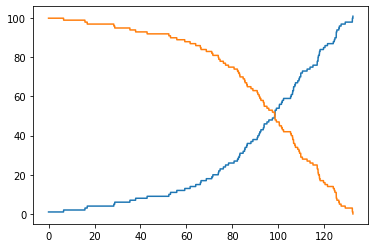

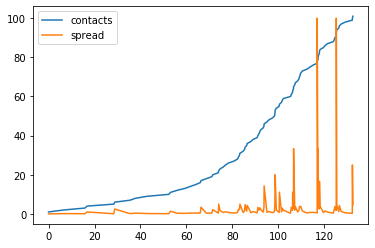

In [163]:
data = exec(nh=100)

zcount = []
hcount = []
time = []

contact_count = []
contact_time = []

for t, z,h , data in data:
    if not zcount or zcount[-1] != z:
        contact_time.append(t)
        contact_count.append(z)

    zcount.append(z)
    hcount.append(h)
    time.append(t)

    

plt.plot(time, zcount)
plt.plot(time, hcount)


plt.figure("spread")
spread = np.diff(contact_count, prepend=1)/np.diff(contact_time, prepend=0)
plt.plot(contact_time, contact_count, label="contacts")
plt.plot(contact_time, spread, label="spread")

plt.legend()
plt.show()



In [164]:
def rolling_mean(x, w):
    data = []
    for i in range(len(x)):
        upper = int(min(i+w/2, len(x)))
        lower = int(max(i-w/2, 0))
        data.append(np.mean(x[lower:upper]))
    return data

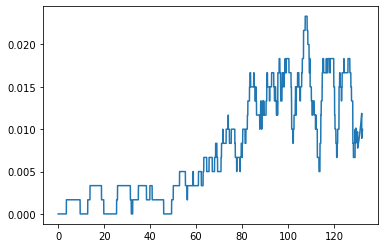

In [175]:
w = 6/(time[1] - time[0])
plt.plot(time, rolling_mean(np.diff(zcount, prepend=1),w))

